In [2]:
import json
import pandas as pd
import numpy as np
import os
from glob import glob
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.ml as M
import pyspark.sql.functions as F
import pyspark.sql.types as T
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
from sklearn.feature_extraction.text import CountVectorizer
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
SparkContext.setSystemProperty('spark.executor.memory', '32g')
sc = SparkContext("local", "App Name")
sc.setLogLevel("ERROR")
spark = SparkSession(sc)
spark.conf.set('spark.ui.showConsoleProgress', True)
spark.conf.set("spark.sql.shuffle.partitions", 8)

In [49]:
#get post label
posts_label_info = glob('/datasets/dsc180a-wi20-public/Malware/group_data/group_02/sensitive_data/interim/label/post/post_sentimental.csv')
posts_label_info = pd.concat([pd.read_csv(i) for i in posts_label_info], ignore_index = True)
max_score = posts_label_info[["toxic", "severe_toxic","obscene","threat","insult","identity_hate"]].max(axis=1)
posts_label_info['comment_label'] = [1 if i > 0.5 else 0 for i in max_score]
posts_label_info.head()

,post_id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_label
0,fsoc27,0.140626,0.001061,0.019116,0.002346,0.032211,0.004757,0
1,fso9w7,0.105921,0.000678,0.015422,0.001588,0.020969,0.003310,0
2,fso9qs,0.003475,0.000018,0.000578,0.000080,0.000675,0.000135,0
3,fso84v,0.012188,0.000062,0.001923,0.000222,0.002200,0.000410,0
4,fso4fh,0.001863,0.000008,0.000459,0.000049,0.000435,0.000096,0


In [50]:
#get post information
posts = glob('/datasets/dsc180a-wi20-public/Malware/group_data/group_02/sensitive_data/raw/posts/*.csv')
posts = pd.concat([pd.read_csv(i) for i in posts], ignore_index = True)
posts.head()

,id,author,title,selftext,num_comments,created_utc,full_link,subreddit,score
0,fsog25,JosephWilde,I now have all the campaign achievements for E...,NaN,4,1585699143,https://www.reddit.com/r/Doom/comments/fsog25/...,Doom,3
1,fsofoi,FthrFlffyBttm,Quick Switching! He just cuts them to shreds i...,NaN,3,1585699106,https://www.reddit.com/r/Doom/comments/fsofoi/...,Doom,3
2,fsofgo,kuiito,yeah it be like that,NaN,0,1585699084,https://www.reddit.com/r/Doom/comments/fsofgo/...,Doom,3
3,fsodoi,Yolo_Hobo_Joe,DOOM 2016 broke. But the aesthetic still works.,NaN,1,1585698907,https://www.reddit.com/r/Doom/comments/fsodoi/...,Doom,2
4,fsoc27,Taker597,*Finished up Slayer Gate on Cultists Base* *Wa...,16/17 items\n\n*Stare off into the dark abyss*,8,1585698738,https://www.reddit.com/r/Doom/comments/fsoc27/...,Doom,3


In [51]:
#merge post and its original label
post_origin_label = pd.merge(posts,posts_label_info[['post_id','comment_label']],how = 'inner',left_on = 'id',right_on = 'post_id')
post_origin_label.head()

,id,author,title,selftext,num_comments,created_utc,full_link,subreddit,score,post_id,comment_label
0,fsoc27,Taker597,*Finished up Slayer Gate on Cultists Base* *Wa...,16/17 items\n\n*Stare off into the dark abyss*,8,1585698738,https://www.reddit.com/r/Doom/comments/fsoc27/...,Doom,3,fsoc27,0
1,fso9w7,Pennywise-Wu-Ha,Battle mode seems really unbalanced,Any one else feel like battlemode favors the d...,29,1585698531,https://www.reddit.com/r/Doom/comments/fso9w7/...,Doom,0,fso9w7,0
2,fso9qs,TheGoddessSwordGamer,Doomslayer identity?,"I just finished the storyline of Eternal, and ...",22,1585698514,https://www.reddit.com/r/Doom/comments/fso9qs/...,Doom,0,fso9qs,0
3,fso84v,Trumpeachment,Screen flickering while playing on PC,Not sure what's up but basically my screen wil...,0,1585698368,https://www.reddit.com/r/Doom/comments/fso84v/...,Doom,1,fso84v,0
4,fso7t8,[deleted],Cant play doom eternal anymore,[deleted],4,1585698338,https://www.reddit.com/r/Doom/comments/fso7t8/...,Doom,1,fso7t8,0


In [52]:
#get information of comment
comments = glob('/datasets/dsc180a-wi20-public/Malware/group_data/group_02/sensitive_data/raw/comments/*.csv')
comments = pd.concat([pd.read_csv(i) for i in comments], ignore_index = True)
#spark.read.format("csv").option("header", "true").load(comments)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning:

Columns (2,3,8) have mixed types.Specify dtype option on import or set low_memory=False.



In [53]:
comments.head()

,id,author,created_utc,is_submitter,subreddit,link_id,body,parent_id,send_replies
0,fm1h6oz,ThePUNisher96,1585678351,True,ShitPoliticsSays,t3_fshz3l,"The voter suppression and ""BUT THEY CHEATED!!!...",t3_fshz3l,True
1,fm1jidw,The_Anti_Soy,1585679560,False,ShitPoliticsSays,t3_fshz3l,Don't they realize that it would be much easie...,t3_fshz3l,True
2,fm1p9tm,Justice_R_Dissenting,1585682552,False,ShitPoliticsSays,t3_fsj68s,Can't wait to see this on the popular tab.,t3_fsj68s,True
3,fm1pffi,Foreverperfect81,1585682633,False,ShitPoliticsSays,t3_fsj68s,https://www.reddit.com/r/Trumpvirus/comments/f...,t3_fsj68s,True
4,fm1pm3t,wokeless_bastard,1585682725,False,ShitPoliticsSays,t3_fsj68s,I wonder if they are calling it the Trumpvirus...,t3_fsj68s,True


In [54]:
#get information of the comment label
comments_label = glob('/datasets/dsc180a-wi20-public/Malware/group_data/group_02/sensitive_data/interim/label/comment/*.csv')
comments_label = pd.concat([pd.read_csv(i) for i in comments_label], ignore_index = True)
#spark.read.format("csv").option("header", "true").load(comments)

In [55]:
comments_label.head()

,comment_id,post_id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,fm2jaf6,fsoare,0.004068,0.000018,0.000727,0.000079,0.000684,0.000141
1,fm2jvnw,fsoe77,0.004068,0.000018,0.000727,0.000079,0.000684,0.000141
2,fm2jw65,fsoeac,0.004068,0.000018,0.000727,0.000079,0.000684,0.000141
3,fm2k482,fsoe3g,0.058218,0.000350,0.008323,0.000942,0.011361,0.001881
4,fm2k51f,fsoe3g,0.018488,0.000099,0.002801,0.000330,0.003437,0.000621


In [9]:
filepath = "/datasets/dsc180a-wi20-public/Malware/group_data/group_02/sensitive_data/raw"

In [13]:
subreddit_info = {'subreddit':[],'num_post':[],'total_comment':[],'avg_comment':[],'top_num_comment':[]}
for filename in os.listdir(filepath + '/posts'):
    if filename.endswith(".csv"):
        subreddit = pd.read_csv(os.path.join(filepath + '/posts', filename))
        #subreddit name
        subreddit_info['subreddit'].append(filename.split('.')[0])
        subreddit_info['num_post'].append(len(subreddit))
        subreddit_info['total_comment'].append(subreddit['num_comments'].sum())
        subreddit_info['avg_comment'].append(int(subreddit['num_comments'].sum()/len(subreddit)))
        subreddit_info['top_num_comment'].append(subreddit['num_comments'].max())
    #break

In [14]:
pd.DataFrame(subreddit_info).sort_values('total_comment',ascending = False)

,subreddit,num_post,total_comment,avg_comment,top_num_comment
38,politics,5000,374963,74,12837
22,pussypassdenied,5000,352941,70,2202
9,TumblrInAction,5000,311407,62,1571
8,conspiracy,10000,223516,22,1664
28,KotakuInAction,5000,223361,44,949
43,amitheasshole,5000,158596,31,2569
33,TopMindsOfReddit,5000,156993,31,2331
44,classicwow,5000,148578,29,1586
21,Drama,5000,131892,26,487
18,ShitPoliticsSays,5000,130240,26,642


In [44]:
#read the labeling for the post
label = '/datasets/dsc180a-wi20-public/Malware/group_data/group_02/sensitive_data/interim/label/label.csv'
post_label = pd.read_csv(label)
post_label.head()

,post_id,label
0,139ze1,0
1,13fxm1,0
2,13qi0z,1
3,147iy1,0
4,148r50,1


In [10]:
post_label.label.value_counts(normalize = True)

 0    0.843948
-1    0.108074
 1    0.047978
Name: label, dtype: float64

In [12]:
import re
post_labeldf = pd.merge(post_label,posts,left_on = 'post_id',right_on = 'id',how = 'inner').drop_duplicates()
hate_benign_post = post_labeldf[(post_labeldf.label == 1) | (post_labeldf.label == 0)]
hate_benign_post['selftext'] = hate_benign_post.selftext.fillna("")
def clean_tweet(tweet): 
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 
hate_benign_post['selftext'] = hate_benign_post['selftext'].apply(clean_tweet)
hate_benign_post['len_content'] = hate_benign_post.selftext.apply(lambda x:len(x.split(" ")))

In [13]:
#number of words of the content of the post for groupby benign and hateful post
hate_benign_post.groupby('label').agg({'len_content':['mean','min','max']})

len_content          
             mean min   max
label                      
0       82.878445   1  7549
1      176.889073   1  7048

In [139]:
for i in range(100):
    print(hate_benign_post['selftext'].iloc[i])

305 992 1040
this a hole has been extremely annoying and rude to all his peers lately will you help me troll him some good ideas to do it blow up his phone with dick pics i think yes send your fanciful texts to 503 550 7110 i m sure they ll go appreciated D
Hello ask That s it That s the last straw Reddit I just want to let you know that I ve grown out of this website This underlying dark philosophy of I don t give a fuck Dark thoughts are humorous and Anarchy gt Order epitomizes the mental flatulence of the population of immature and unappreciative people It hasn t gotten anyone anywhere throughout history and it has only brought me down in the past Trolling to hurt people intentionally isn t funny and if you think it makes you funny intelligent or generally superior you are a master at lying to yourselves One of the important parts of being a man encompasses taking care of the less fortunate and this includes the intellectually less fortunate Atheists Stick to something less extreme 

In [ ]:
#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english')
x = vectorizer.fit_transform(hate_benign_post['selftext'])
#print(vectorizer.get_feature_names())

In [ ]:
feature_array = np.array(vectorizer.get_feature_names())
tfidf_sorting = np.argsort(x.toarray()).flatten()[::-1]
n = 20
top_n = feature_array[tfidf_sorting[:n]]

In [12]:
post_labeldf['count'] = [1]*len(post_labeldf)

In [18]:
subreddit_label = pd.pivot_table(post_labeldf, index=['subreddit'],columns=['label'],values = ['count'],aggfunc=np.sum)
subreddit_label.sort_values(('count',1),ascending = False)

count           
label                    -1     0    1
subreddit                             
incest                 1067  3295  609
tifu                    771  3708  487
TheRedPill             1564  2565  452
Jokes                   766  3758  405
unpopularopinion       1590  2855  404
MGTOW                   264  3084  368
ChapoTrapHouse          159  2917  341
bruhfunny                18  3028  311
teenagers               475  3114  283
TwoXChromosomes         344  3677  256
CringeAnarchy           279  2293  255
pussypassdenied         150  2720  207
EscapefromTarkov        182  3595  194
AmItheAsshole           472  4276  187
ImGoingToHellForThis     84  1881  183
PussyPass               628  1484  182
incest_relationships   1956  2773  179
Doom                    294  3156  172
Wuhan_Flu                68  3413  167
SargonofAkkad             3  2372  165
aznidentity             399  3079  152
Drama                    86  3192  149
DebateAltRight          220  4541  143
MensRights              164  3409  124
multiculturalcancer      59  1081  122
mountandblade           136  3673  115
thedivision             301  4067  110
conspiracy              243  4017  109
The_Donald              184  2922   99
darkmemes                 9  1206   91
FULLCOMMUNISM           175  2583   90
classicwow              241  3746   83
The_Donald_CA           269  1172   78
EDFood                   32  2925   76
AgainstHateSubreddits  1373  1688   75
TheBluePill             697  2564   72
NationalistsUnited        6   426   72
ShitPoliticsSays         60  3507   57
KotakuInAction           32  3905   46
spacedicks                2    78   38
sysadmin                124  4783   37
TumblrInAction           26  3213   31
dndnext                 161  4508   20
TopMindsOfReddit         85  3295   18
personalfinance         552  4371   18
911truth                526  1068   18
politics                146  3135    2

In [13]:
post_label_neg = hate_benign_post[hate_benign_post['label'] == 1.0]

In [14]:
#cleaning the negative post, remove the bot
post_label_neg.author = post_label_neg.author.str.lower()
post_label_neg.subreddit = post_label_neg.subreddit.str.lower()
post_label_neg = post_label_neg[(post_label_neg.author != '[deleted]')&(post_label_neg.author != 'automoderator')& (post_label_neg.author != 'snapshillbot')]
comments['link_id'] = comments.link_id.str[3:]
post_label_neg = post_label_neg[(post_label_neg.id.isin(post_label.post_id)) & (post_label_neg.id.isin(comments.link_id))]


In [15]:
post_label.head()

,post_id,label
0,139ze1,0
1,13fxm1,0
2,13qi0z,1
3,147iy1,0
4,148r50,1


In [16]:
#Merge comment and post
comment_post = pd.merge(post_label_neg,comments_label,how = 'inner', on = 'post_id')

In [17]:
#merge the above with comment information
comment_post_inf = pd.merge(comment_post,comments,how = 'inner',left_on = 'comment_id',right_on = 'id')

In [18]:
comment_post_inf.head()

,post_id,label,id_x,author_x,title,selftext,num_comments,created_utc_x,full_link,subreddit_x,...,identity_hate,id_y,author_y,created_utc_y,is_submitter,subreddit_y,link_id,body,parent_id,send_replies
0,7gh55e,1,7gh55e,heforeverbleeds,A woman receives no jail after confessing to m...,,1,1511993129,https://www.reddit.com/r/PussyPass/comments/7g...,pussypass,...,0.073899,dqke6ou,sl0wdr1pp1n,1512063010,False,PussyPass,7gh55e,"""No sane person would kill a child, so she's n...",t3_7gh55e,NaN
1,7illou,1,7illou,terrichris,One of the Chicago Thugs Who Kidnapped And Tor...,,2,1512806913,https://www.reddit.com/r/PussyPass/comments/7i...,pussypass,...,0.004162,dqzwsnd,ScienceIsA_Joke,1512831102,False,PussyPass,7illou,r/rage\n,t3_7illou,NaN
2,7illou,1,7illou,terrichris,One of the Chicago Thugs Who Kidnapped And Tor...,,2,1512806913,https://www.reddit.com/r/PussyPass/comments/7i...,pussypass,...,0.092880,dqzy2a1,martin59825,1512833040,False,PussyPass,7illou,Being a woman AND black is basically a pass to...,t3_7illou,NaN
3,7kdp9l,1,7kdp9l,homunculusemeritus,"After profiting with $100,000 and staying sile...",,1,1513516307,https://www.reddit.com/r/PussyPass/comments/7k...,pussypass,...,0.027311,drgj90u,nascarracer99316,1513659901,False,PussyPass,7kdp9l,And when someone brings that up she is going t...,t3_7kdp9l,NaN
4,7mptak,1,7mptak,johnkimble111,Woman arrested on suspicion of killing pedestr...,,5,1514498715,https://www.reddit.com/r/PussyPass/comments/7m...,pussypass,...,0.034661,drvqlz7,JohnKimble111,1514498817,True,PussyPass,7mptak,"So she has a history of running over people, i...",t3_7mptak,NaN


In [19]:
#get the label for comment
max_score = comment_post[["toxic", "severe_toxic","obscene","threat","insult","identity_hate"]].max(axis=1)
comment_post_inf['comment_label'] = [1 if i > 0.5 else 0 for i in max_score]

In [20]:
max_score

0        0.947246
1        0.125177
2        0.972270
3        0.674076
4        0.778388
           ...   
77200    0.164045
77201    0.035151
77202    0.714040
77203    0.442854
77204    0.944134
Length: 77205, dtype: float64

## Proportion of users that comment hateful that are involve with hateful speech

In [22]:
comment_post_inf.groupby('author_y')['comment_label'].mean().mean()

0.2815181777524636

### Proportion of users that actually send hateful post who are involve with hateful speech

In [56]:
post_origin_label.author = post_origin_label.author.str.lower()
post_origin_label.subreddit =post_origin_label.subreddit.str.lower()
post_origin_label = post_origin_label[(post_origin_label.author != '[deleted]')&(post_origin_label.author != 'automoderator')& (post_origin_label.author != 'snapshillbot')]
comments['link_id'] = comments.link_id.str[3:]
post_origin_label = post_origin_label[(post_origin_label.post_id.isin(post_label.post_id)) & (post_origin_label.id.isin(comments.link_id))]
post_origin_label

,id,author,title,selftext,num_comments,created_utc,full_link,subreddit,score,post_id,comment_label
0,fsoc27,taker597,*Finished up Slayer Gate on Cultists Base* *Wa...,16/17 items\n\n*Stare off into the dark abyss*,8,1585698738,https://www.reddit.com/r/Doom/comments/fsoc27/...,doom,3,fsoc27,0
1,fso9w7,pennywise-wu-ha,Battle mode seems really unbalanced,Any one else feel like battlemode favors the d...,29,1585698531,https://www.reddit.com/r/Doom/comments/fso9w7/...,doom,0,fso9w7,0
2,fso9qs,thegoddessswordgamer,Doomslayer identity?,"I just finished the storyline of Eternal, and ...",22,1585698514,https://www.reddit.com/r/Doom/comments/fso9qs/...,doom,0,fso9qs,0
8,fsnvr1,corpsie19,Battle mode weapons expert achievement,Does anyone want to go into a private lobby an...,1,1585697136,https://www.reddit.com/r/Doom/comments/fsnvr1/...,doom,1,fsnvr1,0
9,fsnvoi,pastalegion,What is the Praetor suit?,I didn't see any codex entries explaining what...,3,1585697129,https://www.reddit.com/r/Doom/comments/fsnvoi/...,doom,1,fsnvoi,0
...,...,...,...,...,...,...,...,...,...,...,...
106520,fra8lt,natsugrayerza,I’d much rather be with someone who knows he’s...,Humility is overrated. It isn’t a deal breaker...,18,1585505258,https://www.reddit.com/r/unpopularopinion/comm...,unpopularopinion,0,fra8lt,0
106521,fra7o5,k12l30,I like Cardi B,Title pretty much says it all. I have always l...,69,1585505174,https://www.reddit.com/r/unpopularopinion/comm...,unpopularopinion,6,fra7o5,0
106522,fra6wp,halalweed,"Not trusting what mainstream ""scientist"" says ...",Everyone is super gullible when it comes to wh...,16,1585505101,https://www.reddit.com/r/unpopularopinion/comm...,unpopularopinion,0,fra6wp,1
106528,fra429,powerzox,"In a perfect world, you should be paid for the...",Honestly I just want to start a discussion. Al...,8,1585504834,https://www.reddit.com/r/unpopularopinion/comm...,unpopularopinion,2,fra429,0


In [61]:
hateful_post_author = set(post_origin_label.loc[post_origin_label.comment_label == 1,'author'])

In [64]:
len(hateful_post_author.union(set(comment_post_inf.loc[comment_post_inf.comment_label == 1,'author_y'])))

16828

In [65]:
len(hateful_post_author.union(set(comment_post_inf.author_y)))

38019

In [67]:
16828/38019

0.44262079486572503

# Text analysis

In [14]:
post_label_pos =  hate_benign_post[hate_benign_post['label'] == 0]

In [15]:
post_labeldf.groupby('label').agg({'num_comments' : ['min', 'max','count','mean']})

num_comments                         
               min   max   count       mean
label                                      
-1               0   729   17442   1.762986
 0               0  9783  138118  24.305181
 1               0  2043    7852  16.895441

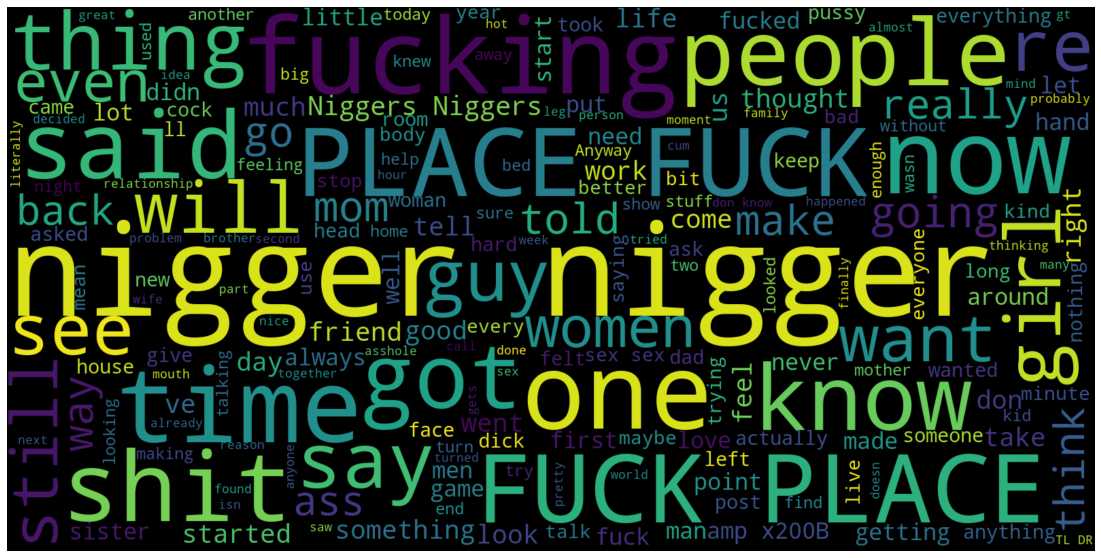

In [15]:
text = " ".join(review for review in post_label_neg.selftext)

# Create and generate a word cloud image:
wordcloud = WordCloud(width = 1600,height = 800).generate(text)

# Display the generated image:
plt.figure(figsize = (20,10))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [34]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(post_label_neg.selftext, 30)
#for word, freq in common_words:
   # print(word, freq)
hateful_word = pd.DataFrame(common_words, columns = ['title' , 'count'])
#df2.groupby('title').sum()['count'].sort_values(ascending=False).iplot(
   # kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

In [20]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(post_label_neg.selftext, 20)
#for word, freq in common_words:
#    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['title' , 'count'])
#df4.groupby('title').sum()['count'].sort_values(ascending=False).iplot(
#    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

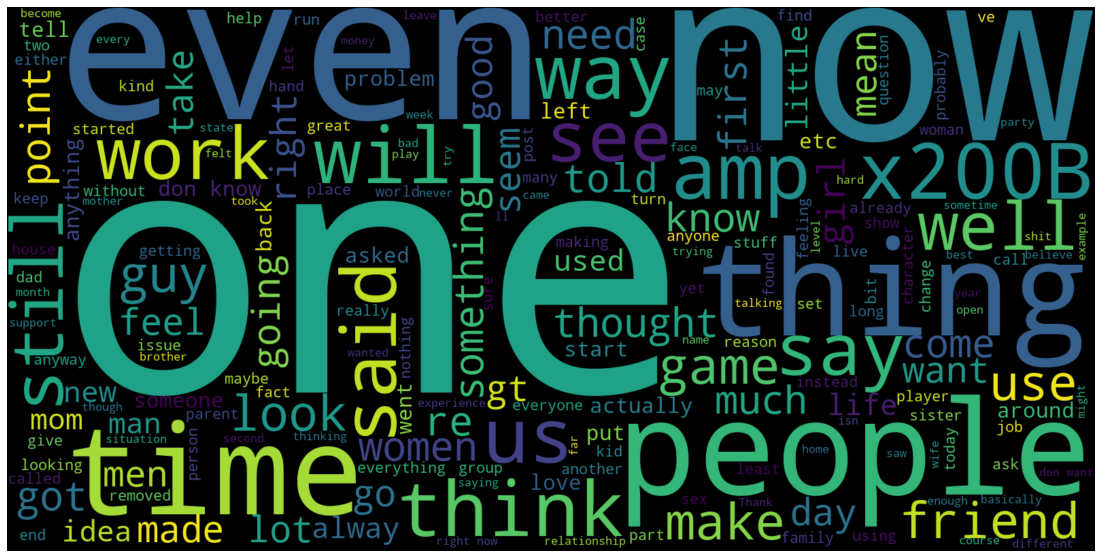

In [18]:
text = " ".join(review for review in post_label_pos.selftext)

# Create and generate a word cloud image:
wordcloud = WordCloud(width = 1600,height = 800).generate(text)

# Display the generated image:
plt.figure(figsize = (20,10))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [36]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(post_label_pos.selftext, 30)
#for word, freq in common_words:
#    print(word, freq)
benign_word = pd.DataFrame(common_words, columns = ['title' , 'count'])
#df2.groupby('title').sum()['count'].sort_values(ascending=False).iplot(
#    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

In [43]:
#eliminate the words that occured in both group
merge_two = pd.merge(hateful_word,benign_word, on = 'title',how = 'outer')
malign_count = merge_two.loc[merge_two['count_y'].isna(),['title','count_x']]
malign_count

,title,count_x
2,fuck,5835.0
3,nigger,4078.0
6,fucking,3233.0
8,shit,2907.0
10,place,2713.0
15,sex,2200.0
23,started,1840.0
24,ass,1800.0
26,went,1717.0


In [44]:
benign_count = merge_two.loc[merge_two['count_x'].isna(),['title','count_y']]
benign_count

,title,count_y
30,amp,13155.0
31,work,12508.0
32,feel,12388.0
33,right,12208.0
34,gt,11256.0
35,things,11244.0
36,new,11002.0
37,need,10629.0
38,years,10374.0


In [20]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(post_label_pos.selftext, 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['title' , 'count'])
df4.groupby('title').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

amp x200b 9234
don know 4388
feel like 3418
don want 2788
tl dr 2463
anita sarkeesian 2066
sarkeesian anita 2047
gt gt 1775
years ago 1686
year old 1543
covid 19 1534
don think 1484
didn want 1340
ve seen 1219
felt like 1140
make sure 1137
long time 1093
let know 1049
didn know 1049
just want 1019
